In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms.v2 as T
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
train_data = torchvision.datasets.ImageFolder(
    "../data/train",
    transform=T.Compose([
        T.Resize((128, 128)),
        T.ToImage(),
        T.ToDtype(torch.float, scale=True),
    ])
)
val_data = torchvision.datasets.ImageFolder(
    "../data/test",
    transform=T.Compose([
        T.Resize((128, 128)),
        T.ToImage(),
        T.ToDtype(torch.float, scale=True),
    ])
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: '../celeba_hq/train'

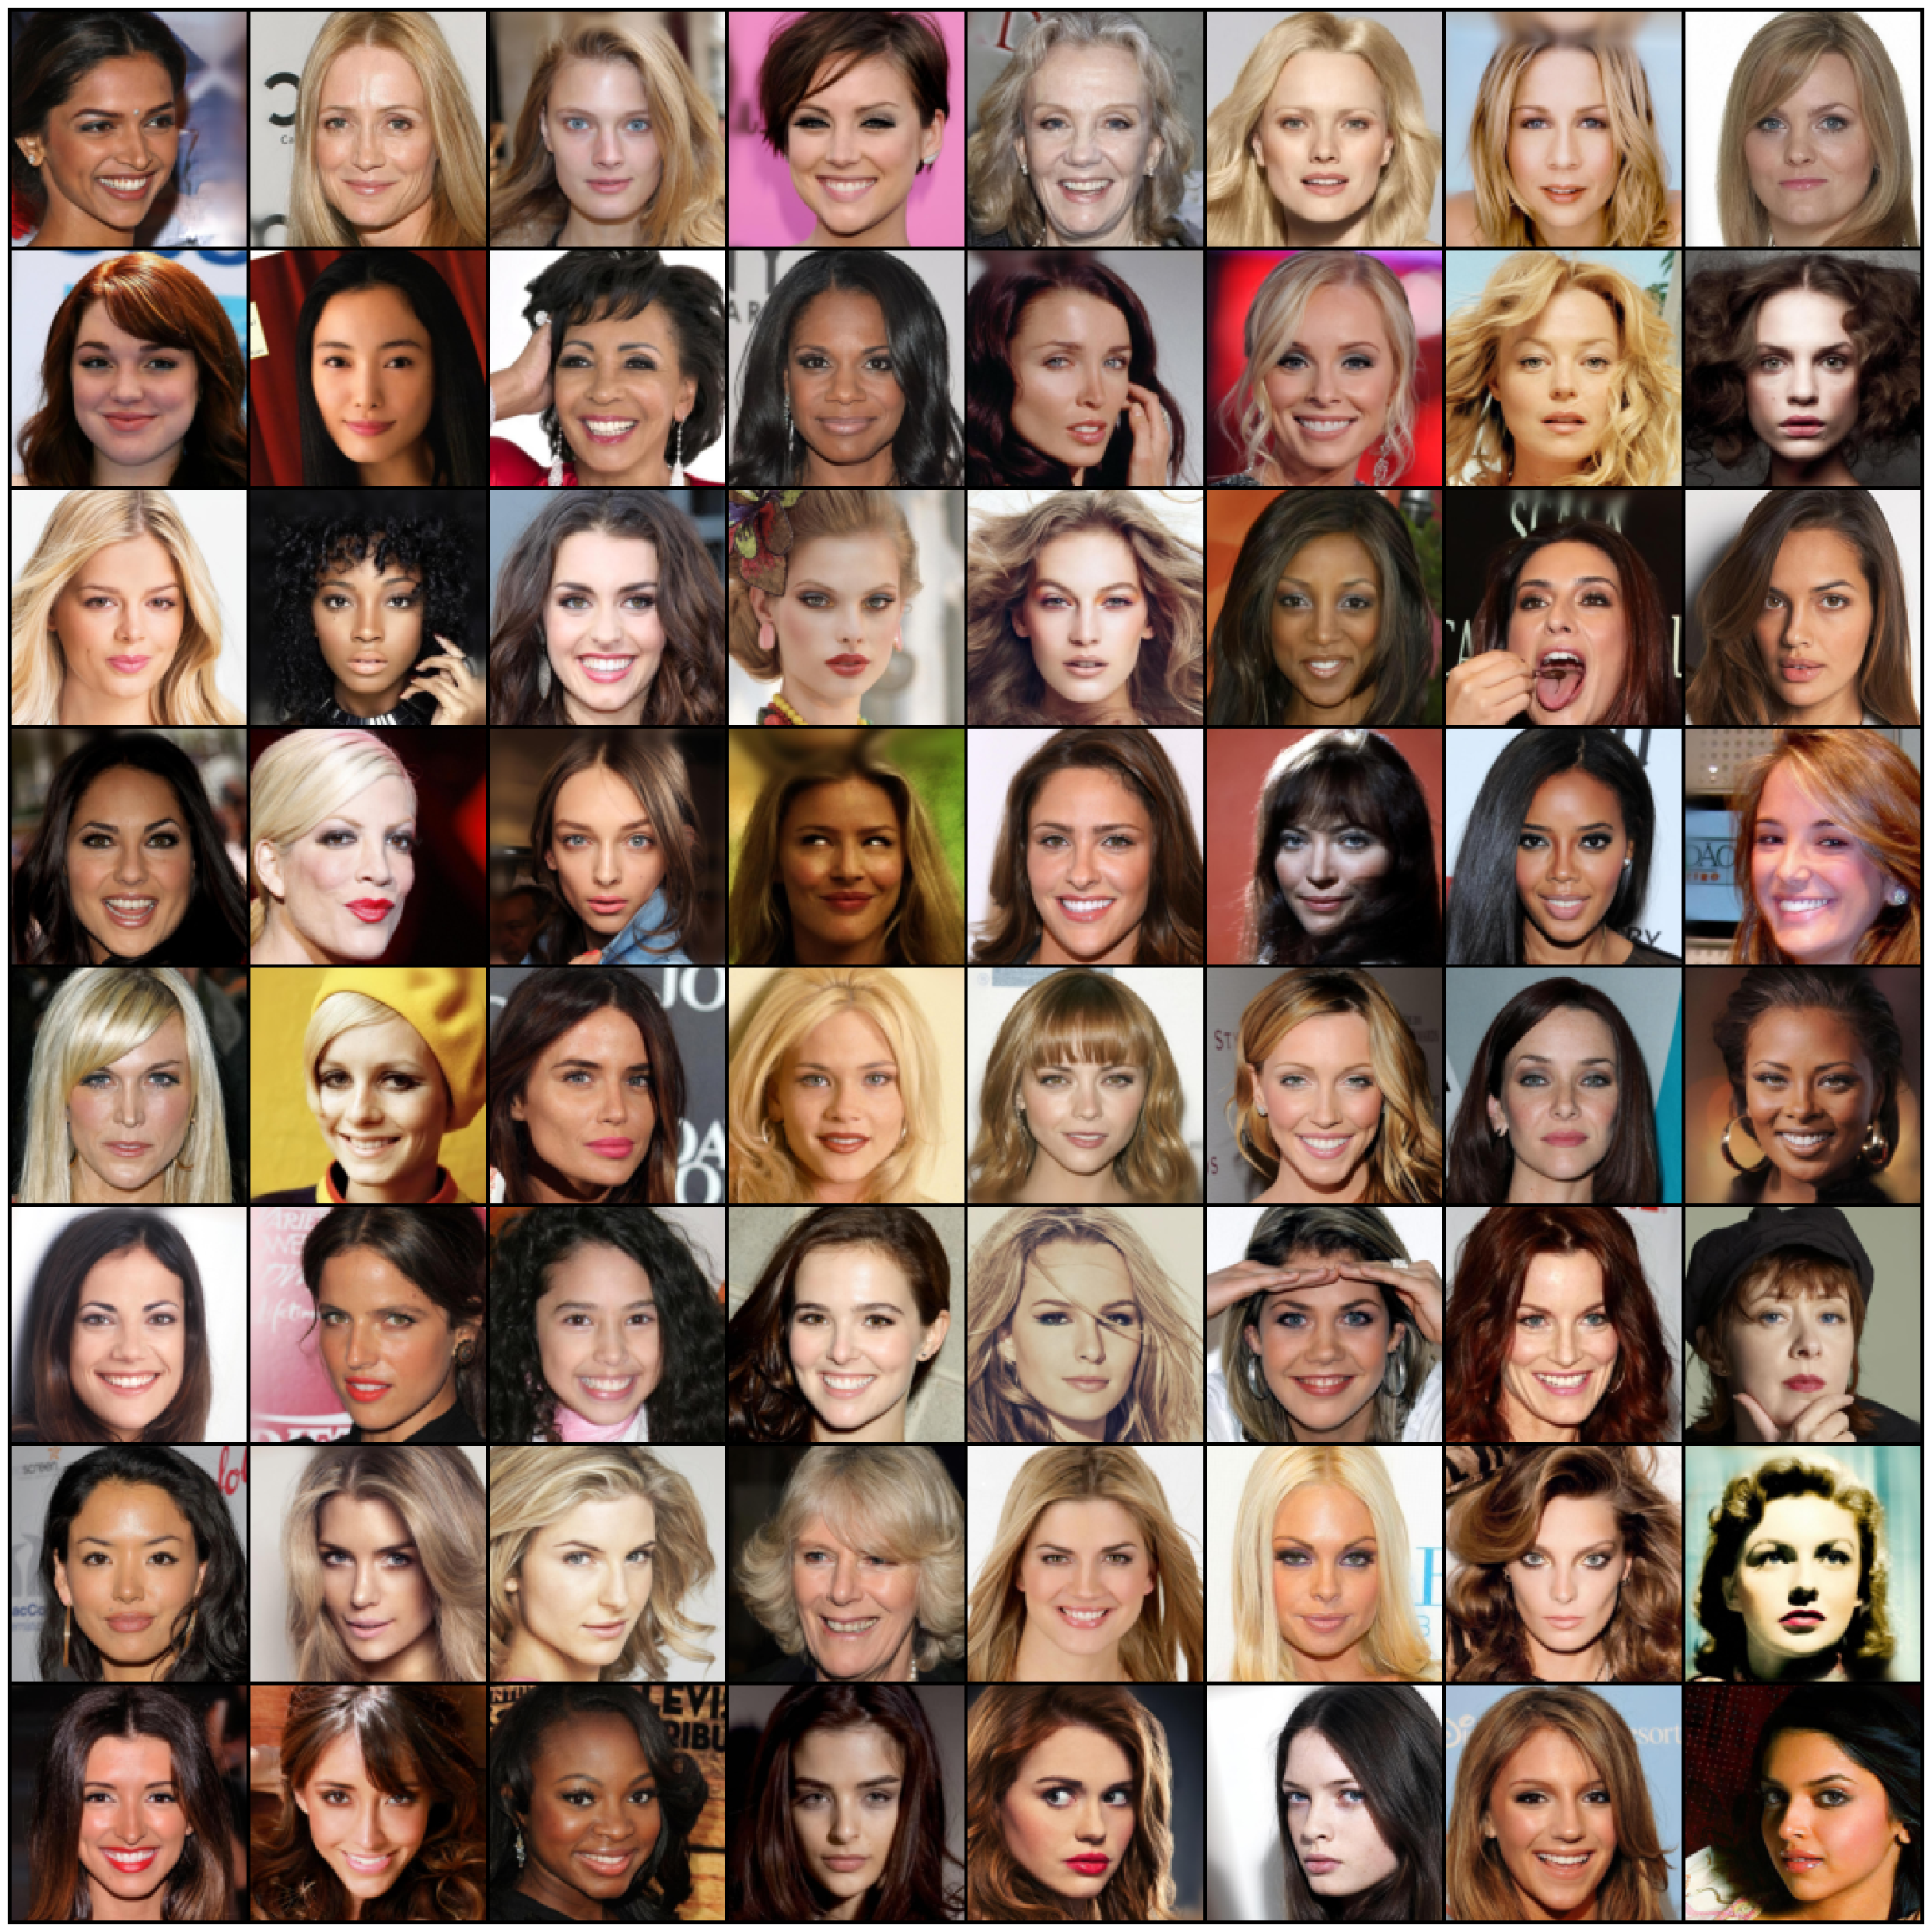

In [5]:
x, _ = next(iter(val_loader))
plt.figure(figsize=(32, 32))
plt.imshow(torchvision.utils.make_grid(x, nrow=8).permute(1, 2, 0), interpolation="nearest")
plt.axis("off")
plt.show()

In [12]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
        self.px1 = nn.PixelShuffle(2)
        self.conv2 = nn.Conv2d(64 // 4, 64, 3, 1, 1)
        # self.px2 = nn.PixelShuffle(2)
        self.conv3 = nn.Conv2d(64, 3, 3, 1, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.px1(x))
        x = F.relu(self.conv2(x))
        # x = F.relu(self.px2(x))
        x = torch.sigmoid(self.conv3(x))
        return x
    
model = Model()
summary(model, (64, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3, 128, 128]         --
├─Conv2d: 1-1                            [64, 64, 64, 64]          1,792
├─PixelShuffle: 1-2                      [64, 16, 128, 128]        --
├─Conv2d: 1-3                            [64, 64, 128, 128]        9,280
├─Conv2d: 1-4                            [64, 3, 128, 128]         1,731
Total params: 12,803
Trainable params: 12,803
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 12.02
Input size (MB): 3.15
Forward/backward pass size (MB): 696.25
Params size (MB): 0.05
Estimated Total Size (MB): 699.45

In [13]:
model.to("mps")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [15]:
for epoch in range(10):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
    for x, _ in pbar:
        optimizer.zero_grad()
        x = x.to("mps")
        sm_x = F.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)
        lg_x = x
        
        out = model(sm_x)
        loss = criterion(out, lg_x)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item(), psnr=10 * torch.log10(1 / loss).item())
        
    model.eval()
    with torch.no_grad():
        losses = []
        for x, _ in val_loader:
            x = x.to("mps")
            sm_x = F.interpolate(x, scale_factor=0.5, mode="bilinear", align_corners=False)
            lg_x = x
            
            out = model(sm_x)
            loss = criterion(out, lg_x)
            losses.append(loss.item())
        print(f"Validation loss: {sum(losses) / len(losses)}")
        
    x = sm_x[:8].cpu()
    y = model(x).cpu()
    plt.figure(figsize=(32, 32))
    plt.subplot(1, 2, 1)
    plt.imshow(torchvision.utils.make_grid(x, nrow=8).permute(1, 2, 0), interpolation="nearest")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(torchvision.utils.make_grid(y, nrow=8).permute(1, 2, 0), interpolation="nearest")
    plt.axis("off")
    plt.show()
    
    

Epoch 1:   1%|▏         | 6/438 [00:03<03:40,  1.96it/s, loss=0.0107, psnr=19.7]


KeyboardInterrupt: 